In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV


PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20% of predictions
ITERATIONS = 100  # Bootstrap iterations
COLORS = ['#323694', '#039573', '#feea2a'] # Color palette for the classifiers


# CMIM ranking of features 
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']


## `EssentiallyClassifier` Class

The `EssentiallyClassifier` class is an abstract base class designed to be implemented by diffent classifiers algorithms provviding a common interface for all classifiers.

In [101]:

class EssentiallyClassifier:
    """
    Abstract class for the essentiality classifier.
    Contains the main methods to load the data, find the optimal number of features and plot the results.
    """

    def __init__(self, file_path, cmim_ranking, percentiles,name, skip_discretization=False):
        self.name = name # Name of classifier
        self.file_path = file_path # Path to the excel file
        self.cmim_ranking = cmim_ranking # CMIM ranking of features 
        self.percentiles = percentiles # Top percentiles 
        self.X = None # Features
        self.y = None # Labels of Grand truth
        self.optimal_features = None # Optimal number of features to use
        self.highest_ppv_5 = 0 # Highest PPV (5%), used to find optimal number of features 
        self.final_ppv_scores = [] # Final PPV scores for the top percentiles
        self.final_fpr = [] # Final FPR scores
        self.final_tpr = [] # Final TPR scores
        self.final_auc = None # Final AUC score
        self.categories = None # Number of unique categories in the data
        self.skip_discretization = skip_discretization # Load the data without discretization


    def load_data(self):
        """
        Loads the data with the specified method.
        """
        self.load_discretized_data() if not self.skip_discretization else self.load_raw_data()


    def load_raw_data(self):
        """
        Loads the data without discretization.
        """
        data = pd.read_excel(self.file_path)
        self.X = data.drop(columns=['Essential', 'orf_id'])
        self.y = data['Essential']

        print("Row data loaded successfully, shape:", self.X.shape, self.y.shape)
        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)
        print("Data saved successfully");

    def load_discretized_data(self):
        """
        Loads and processes discretized data from an Excel file.
        Reads data and uses a label encoder to convert symbols to integers.
        Counts the number of unique categories in the data.
        """
        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

        # Count the number of unique categories in the data
        min_categories = self.X.nunique()
        self.categories = min_categories  

        print("Discretized data loaded successfully, shape:", self.X.shape, self.y.shape)
        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)
        print("Data saved successfully")



    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        """
        Calculate the positive predictive value (PPV) for the top percentiles of predictions.

        Parameters:
            - probabilities: Array of predicted probabilities.
            - true_labels: Grand truth labels.
        
        Returns:
        - PPV values for each specified percentile in self.percentiles.
        """

        if len(probabilities) != len(true_labels):
            raise ValueError("Length of probabilities and true labels must be the same.")

        sorted_indices = np.argsort(probabilities)[::-1] # Sort probabilities in descending order so that the top probabilities are first
        sorted_labels = true_labels[sorted_indices] # Sort true labels according to the sorted probabilities
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100)) # Calc the number of top predictions to consider
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                # def: PPV = TP / (TP + FP)
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles


    def find_optimal_features(self):
        """
        Find the optimal number of features to use by evaluating the classifier with different number 
        of features taken ordered by CMIM ranking.
        """

        # Only features of the specific feature set 
        X_ranked = self.X[self.cmim_ranking]

        print("Starting to find optimal number of features...")

        # Iterate over all the features in the specific CMIM ranking
        for i in range(len(self.cmim_ranking), 0, -1):
            X_selected = X_ranked.iloc[:, :i]

            # Evaluate the model with the selected features
            res = self.evaluate_model(X_selected)
            ppv = res[0]
            
            ppv_1 = ppv[0] # PPV (1%)
            ppv_5 = ppv[1] # PPV (5%)
            print(f"Features: {i}, PPV (1%): {ppv_1}, PPV (5%): {ppv_5}")

            # Update the highest PPV (1%) and optimal number of features
            if ppv_5 > self.highest_ppv_5 and ppv_1 > ppv_5:
                self.highest_ppv_5 = ppv_5
                self.optimal_features = i


        # Print the results
        print("Highest PPV (5%):", self.highest_ppv_5)
        print("Optimal number of features:", self.optimal_features, self.cmim_ranking[:self.optimal_features])



    def evaluate_final_model(self):
        """
        Evaluate the final model with the optimal number of features.
        """

        if self.optimal_features is None:
            raise ValueError("Optimal number of features to use has not been found.") 

        # Use the optimal number of features found empirically
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]


        # Evaluate the model with the optimal number of features
        self.final_ppv_scores, self.final_fpr, self.final_tpr, self.final_auc = self.evaluate_model(X_optimal)
    
        print("Final PPV Percentiles:", self.final_ppv_scores)
        
        return self.final_ppv_scores



    def plot_ppv_results(self, ppv):
        """
        Plot the PPV results for the final model and compare with random predictions.

        Parameters:
            - ppv: Array of PPV values for the top percentiles of predictions of the classifier.
        """

        fig, ax = plt.subplots(figsize=(6, 4))
        percentiles_labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        bar_with = 0.2

        ax.bar(np.arange(len(self.percentiles)) - bar_with / 2, ppv, bar_with, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + bar_with / 2, random_ppv, bar_with, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(percentiles_labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()


    def plot_final_roc_curve(self):
        """
        Plot the final ROC curve for the classifier.
        """
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(self.final_fpr, self.final_tpr, color='blue', label=self.name + f' (AUC = {self.final_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for {self.name}')
        ax.legend()
        fig.tight_layout()
        plt.show()
        


    def run(self):
        """
        Build, optimize and evaluate the classifier.
        """

        self.load_data()
        self.find_optimal_features() 
        ppvs = self.evaluate_final_model()
        self.plot_ppv_results(ppvs)
        self.plot_final_roc_curve()



    def evaluate_model(self, X_selected):
        """
        Evaluate the model with the selected features and calculate the PPV for the top percentiles of predictions.

        Parameters:
        - X_selected: Selected features to use for the model.
        
        Returns:
        - PPV values for the top percentiles of predictions.

        To be implemented by the subclass.
        """
        pass


## `EssentiallyBayesClassifier` Class

The `EssentiallyBayesClassifier` class is a specialized implementation of the `EssentiallyClassifier` abstract base class. It utilizes a Naive Bayes classifier to perform essentiality prediction tasks. 
The implementation uses the boostrapping technique.


In [102]:
class EssentiallyBayesClassifier(EssentiallyClassifier):
    """
    Naive Bayes classifier for the essentiality prediction.
    """

    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles ,name)


    def calcolate_boostrap_iteration(self, X_selected):
        """
        Helper function to calculate the single bootstrap iteration for the Naive Bayes classifier.

        Parameters:
            - X_selected: Selected features to use.

        Returns:
            - PPV values for the top percentiles of predictions.
            - FPR values of various percentiles
            - TPR values of various percentiles
        """


        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        selected_categories = self.categories[X_selected.columns].to_numpy()

        
        nb_classifier = CategoricalNB(min_categories=selected_categories)
        nb_classifier.fit(X_train, y_train)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]
     
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy()), fpr, tpr, auc

   
    # Override 
    def evaluate_model(self, X_selected):
        all_ppvs = []
        all_fpr = []
        all_tpr = []
        all_auc = []

        for _ in range(ITERATIONS):  # Bootstrap iterations
            ppv_iteration, fpr_iteration, tpr_iteration, auc_iteration = self.calcolate_boostrap_iteration(X_selected)
            all_ppvs.append(ppv_iteration)
            all_fpr.append(fpr_iteration)
            all_tpr.append(tpr_iteration)
            all_auc.append(auc_iteration)

        # Calculate the mean PPV for each percentile over all iterations
        mean_ppv = np.mean(all_ppvs, axis=0)

        # Calculate the mean FPR and TPR for each percentile over all iterations through interpolation 
        # (as the number of thresholds  can be different in each iteration)
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.zeros_like(mean_fpr) 

        for fpr, tpr in zip(all_fpr, all_tpr):
            mean_tpr += np.interp(mean_fpr, fpr, tpr) 

        mean_tpr /= ITERATIONS  


        mean_auc = np.mean(all_auc)

        # Restituiamo il PPV medio, FPR medio e TPR medio
        return mean_ppv, mean_fpr, mean_tpr, mean_auc

## `EssentialityExperiment` Class

The `EssentialityExperiment` class is designed to manage and run and compare multiple classifiers.
It inclueds methods for executing experiments, visualizing omparative tables and plots.


In [103]:
class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name # Name of the experiment
        self.classifiers = classifiers # Classifiers to run and compare

    def run_experiment(self):
        """
        Runs all the classifiers and evaluates their performance.
        """

        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
    
    def plot_and_save_comparative_results(self, percentiles, colors=None):
        """
        Plot the comparative results of the classifiers.
        """

        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors # get default color map if not specified

        fig, ax = plt.subplots(figsize=(6, 4))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        bar_width = 0.1
        gap = 0.03  # Gap between bars in the same group

        # Plot the PPV scores for each classifier
        for idx, classifier in enumerate(self.classifiers):
            ax.bar(x + idx * (bar_width + gap), 
                np.array(classifier.final_ppv_scores) * 100,  
                bar_width, 
                label=classifier.name, 
                color=colors[idx % len(colors)],
                edgecolor='black', 
                linewidth=0.4)  

        # Random predictions
        random_ppv = [np.mean(self.classifiers[0].y) * 100] * len(percentiles)
        ax.bar(x + (len(self.classifiers)) * (bar_width + gap), 
            random_ppv, 
            bar_width, 
            label='Random', 
            color='black', 
            edgecolor='black', 
            linewidth=0.5)

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + (len(self.classifiers) / 2) * (bar_width + gap) )
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 100) 
        ax.legend()
        fig.tight_layout()
        plt.show()

        # Save the plot to a file
        fig.savefig(f'./output/{self.name}_ppv_plot.png')


    def plot_and_save_comparative_table(self):
        """
        Plot a comparative table of the final PPV scores for each classifier.
        """
 
        rows = []
        for classifier in self.classifiers:
            if len(classifier.final_ppv_scores) != len(PERCENTILES):
                raise ValueError(
                    f"Inconsistent length for classifier '{classifier.name}': "
                    f"expected {len(PERCENTILES)} scores, got {len(classifier.final_ppv_scores)}."
                )
            rounded_scores = [str(round(score, 2)) for score in classifier.final_ppv_scores]
            rows.append(
                [classifier.name] + rounded_scores + [classifier.optimal_features]
            )

        # Create DataFrame
        columns = ['Classifier'] + [f'{p}%' for p in PERCENTILES] + ['Number of Features']
        table_df = pd.DataFrame(rows, columns=columns)
        table_df.set_index('Classifier', inplace=True)

        # Define a color palette for each row
        colors = [f'{color}50' for color in COLORS]  # Add alpha chanel to colors
        color_map = {classifier.name: colors[i % len(colors)] for i, classifier in enumerate(self.classifiers)}

     
        def highlight_row(row):
            classifier = row.name
            color = color_map.get(classifier, '#FFFFFF')  
            return [f'background-color: {color};'] * len(row)

        styled_df = table_df.style.apply(highlight_row, axis=1)


        styled_df = styled_df.set_table_attributes('style="font-size: 14px; border-collapse: collapse;"')


        # Save the table to a CSV file
        table_df.to_csv(f'./output/{self.name}_ppv_table.csv')


        return styled_df


Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9160869565217393, PPV (5%): 0.7590677966101697
Features: 41, PPV (1%): 0.9221739130434792, PPV (5%): 0.753728813559322
Features: 40, PPV (1%): 0.917826086956522, PPV (5%): 0.7538983050847459
Features: 39, PPV (1%): 0.9234782608695662, PPV (5%): 0.7561016949152544
Features: 38, PPV (1%): 0.9282608695652182, PPV (5%): 0.7598305084745764
Features: 37, PPV (1%): 0.916956521739131, PPV (5%): 0.7624576271186441
Features: 36, PPV (1%): 0.9213043478260876, PPV (5%): 0.7622881355932204
Features: 35, PPV (1%): 0.9195652173913049, PPV (5%): 0.7584745762711864
Features: 34, PPV (1%): 0.922173913043479, PPV (5%): 0.7631355932203391
Features: 33, PPV (1%): 0.9156521739130432, PPV (5%): 0.7611864406779659
Features: 32, PPV (1%): 0.9126086956521745, PPV (5%): 0.751101694915254
Features: 31, PPV (1%): 0.9221739130434793, PPV (5%): 0.77338983050

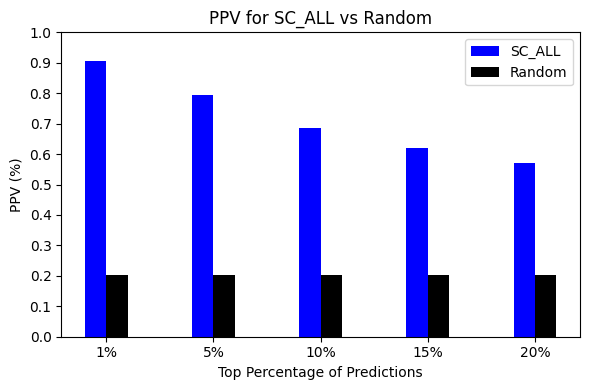

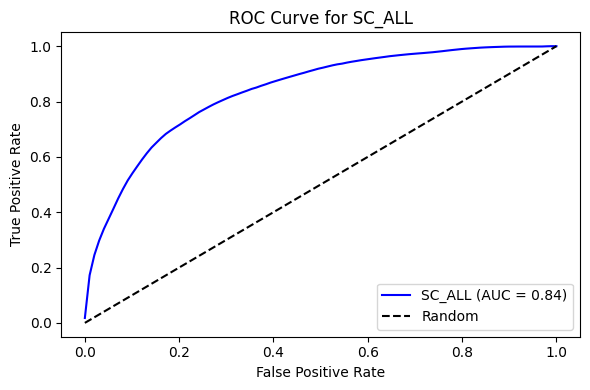

In [104]:
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')
classifier_all.run()



--------------------------------------------------------------------------------
Running experiment for S. cerevisiae
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.919130434782609, PPV (5%): 0.7606779661016952
Features: 41, PPV (1%): 0.9108695652173918, PPV (5%): 0.7599152542372888
Features: 40, PPV (1%): 0.9156521739130441, PPV (5%): 0.7629661016949153
Features: 39, PPV (1%): 0.9165217391304351, PPV (5%): 0.7577966101694912
Features: 38, PPV (1%): 0.92, PPV (5%): 0.755338983050847
Features: 37, PPV (1%): 0.9143478260869567, PPV (5%): 0.7579661016949152
Features: 36, PPV (1%): 0.9156521739130435, PPV (5%): 0.7589830508474578
Features: 35, PPV (1%): 0.922173913043

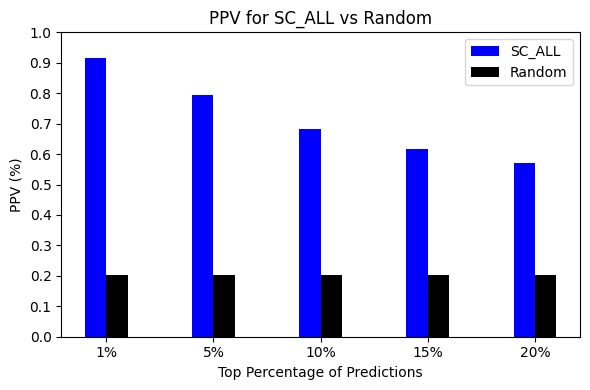

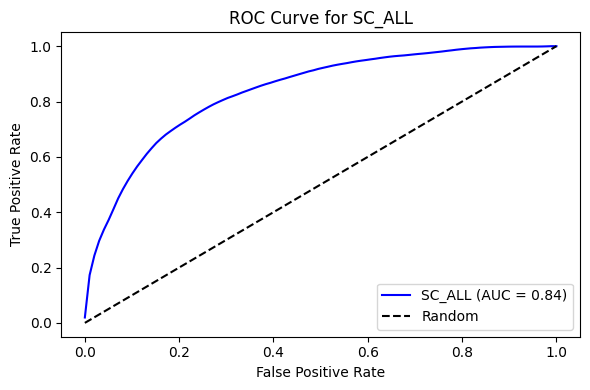

Running classifier SC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.8134782608695652, PPV (5%): 0.6550847457627116
Features: 15, PPV (1%): 0.8165217391304345, PPV (5%): 0.6768644067796612
Features: 14, PPV (1%): 0.8269565217391301, PPV (5%): 0.6669491525423726
Features: 13, PPV (1%): 0.8169565217391304, PPV (5%): 0.6735593220338982
Features: 12, PPV (1%): 0.8273913043478259, PPV (5%): 0.6971186440677968
Features: 11, PPV (1%): 0.8369565217391297, PPV (5%): 0.7176271186440679
Features: 10, PPV (1%): 0.8347826086956516, PPV (5%): 0.7160169491525423
Features: 9, PPV (1%): 0.8639130434782605, PPV (5%): 0.700762711864407
Features: 8, PPV (1%): 0.853043478260869, PPV (5%): 0.6944067796610169
Features: 7, PPV (1%): 0.8352173913043476, PPV (5%): 0.6897457627118639
Features: 6, PPV (1%): 0.8191304347826085, PPV (5%): 0.6856

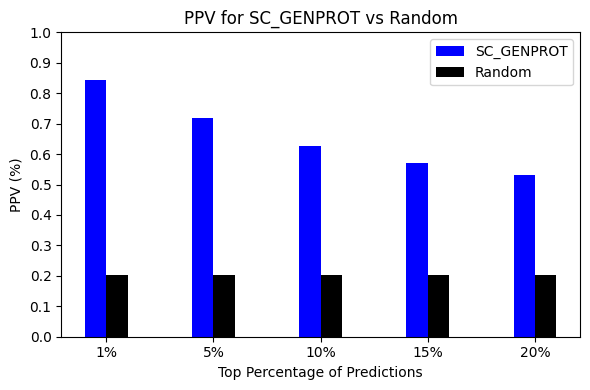

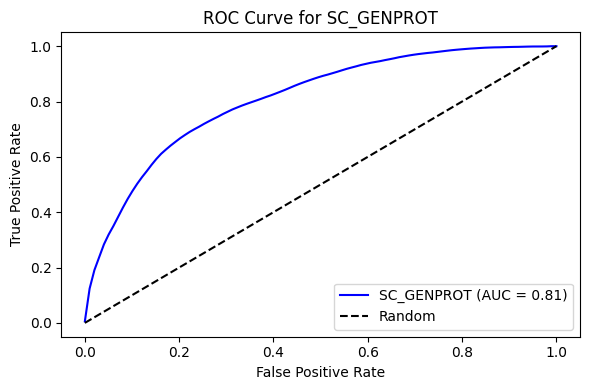

Running classifier SC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.6482608695652177, PPV (5%): 0.5200847457627119
Features: 14, PPV (1%): 0.6152173913043482, PPV (5%): 0.5134745762711864
Features: 13, PPV (1%): 0.6065217391304351, PPV (5%): 0.5228813559322033
Features: 12, PPV (1%): 0.566521739130435, PPV (5%): 0.4556779661016951
Features: 11, PPV (1%): 0.5560869565217392, PPV (5%): 0.4517796610169492
Features: 10, PPV (1%): 0.5391304347826092, PPV (5%): 0.46415254237288117
Features: 9, PPV (1%): 0.4713043478260872, PPV (5%): 0.49754237288135583
Features: 8, PPV (1%): 0.4839130434782609, PPV (5%): 0.506779661016949
Features: 7, PPV (1%): 0.5217391304347827, PPV (5%): 0.5256779661016949
Features: 6, PPV (1%): 0.5008695652173915, PPV (5%): 0.534491525423729
Features: 5, PPV (1%): 0.5073913043478263, PPV (5%): 0.5

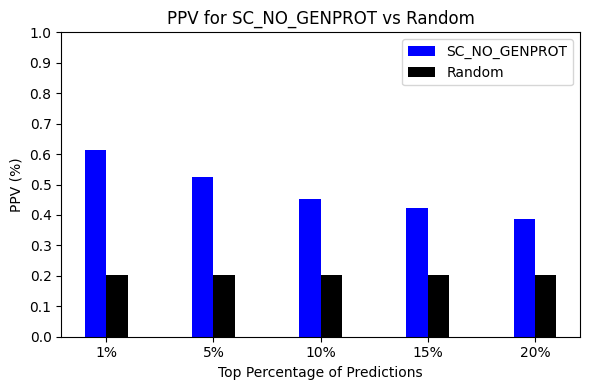

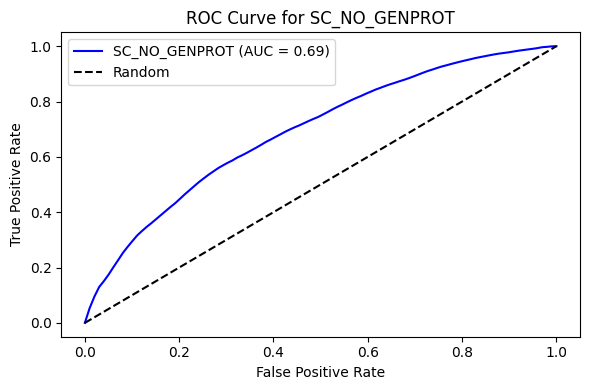

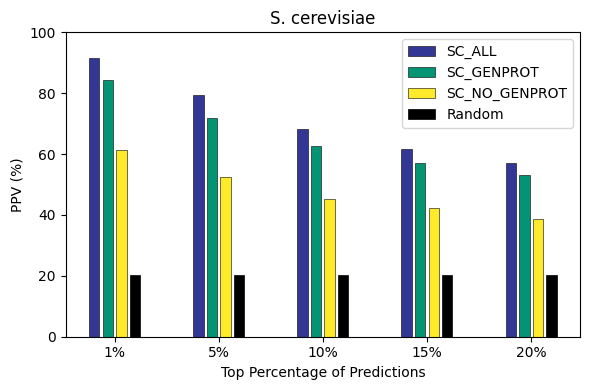

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.91,0.79,0.68,0.62,0.57,22
SC_GENPROT,0.84,0.72,0.63,0.57,0.53,11
SC_NO_GENPROT,0.61,0.52,0.45,0.42,0.39,13


In [105]:


classifier_no_genprot_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae", [classifier_all_nb, classifier_genprot_nb, classifier_no_genprot_nb])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS)
experiment.plot_and_save_comparative_table()



In [125]:
class EssentialityRandomForestClassifier(EssentiallyClassifier):
    """
    Random Forest classifier for the essentiality prediction.
    """


    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles,name, skip_discretization=False)

        self.rf_classifier = None # Random Forest classifier

   
    # Override
    def evaluate_model(self, X_selected):

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        # Build the Random Forest classifier
        # self.rf_classifier = RandomForestClassifier(
        #     n_estimators=200,           # Number of trees (default=100)
        #     max_depth=30,               # Maximum depth. Default is None, meaning nodes are expanded until all leaves are pure. Deeper trees can capture more details but may overfit.
        #     min_samples_split=5,        # Minimum number of samples required to split a node. Higher values reduce overfitting but may lead to simpler models. (default=2)
        #     min_samples_leaf=2,         # Minimum number of samples required to be at a leaf node. Each leaf must contain at least this number of samples, reducing the tree's ability to adapt to very specific details.
        #     max_features='sqrt',        # Number of features to consider when looking for the best split: The number of features considered is the square root of the total number of features (e.g., if you have 100 features, each tree will consider 10 features).
        #     class_weight='balanced',    # Handle imbalanced classes. Weighs classes to handle imbalanced datasets. Improves performance when one class is underrepresented.
        #     n_jobs=-1                   # Parallel execution (-1 to use all cores)
        # )
        #self.rf_classifier = RandomForestClassifier()

        param_grid = {
            'n_estimators': [100,200,300],
            'max_depth': [10, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'max_features': ['sqrt', 'log2', None],
            'class_weight': ['balanced']
        }

        rf = RandomForestClassifier(random_state=42, n_jobs=-1)
        grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        self.rf_classifier = grid_search.best_estimator_


        # Train the Random Forest classifier
        self.rf_classifier.fit(X_train, y_train)
        y_prob = self.rf_classifier.predict_proba(X_test)[:, 1]

        ppv_iteration = self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)


        return ppv_iteration, fpr, tpr, auc
    


    def plot_feature_importance(self):
        """
        Plot the feature importance of the Random Forest classifier.
        """

        importances = self.rf_classifier.feature_importances_
        feature_names = self.X[self.cmim_ranking].iloc[:, :self.optimal_features].columns

        plt.figure(figsize=(5, 6))  # Adjust figure size based on the number of features
        plt.barh(feature_names, importances)
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance in Random Forest for {self.name}")
        plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names, va='center', fontsize=10)
        plt.tight_layout()
        plt.show()

    # Extend run method
    def run(self):
        super().run()
        self.plot_feature_importance()

In [ ]:


classifier_no_genprot_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae Random Forest", [classifier_all_rf, classifier_genprot_rf, classifier_no_genprot_rf])

experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])
experiment.plot_and_save_comparative_table()




--------------------------------------------------------------------------------
Running experiment for S. cerevisiae Random Forest
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Data saved successfully
Starting to find optimal number of features...


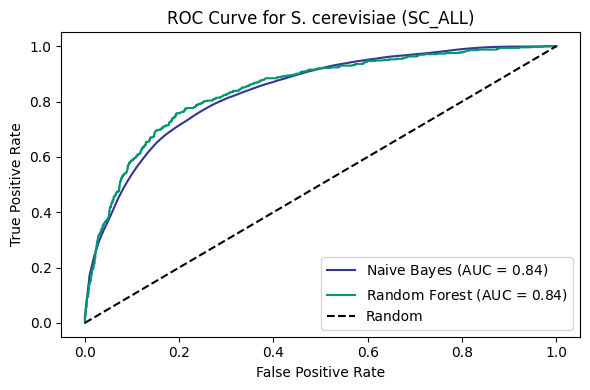

In [122]:
# Compare roc curves of naive bayes and random forest for SC_ALL
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(classifier_all_nb.final_fpr, classifier_all_nb.final_tpr, color='#323694', label='Naive Bayes (AUC = ${:.2f}$)'.format(classifier_all.final_auc))
ax.plot(classifier_all_rf.final_fpr, classifier_all_rf.final_tpr, color='#039573', label='Random Forest (AUC = ${:.2f}$)'.format(classifier_all.final_auc))
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for S. cerevisiae (SC_ALL)')
ax.legend()
fig.tight_layout()

